# 2023-04-21 Stiff equations

## Last time

* Notes on integration
* Ordinary differential equations (ODE)
* Explicit methods for solving ODE
* Stability

## Today

* Implicit and explicit methods
* Stiff equations
* PDE examples

In [1]:
using LinearAlgebra
using Plots
default(linewidth=4, legendfontsize=12)

struct RKTable
    A::Matrix
    b::Vector
    c::Vector
    function RKTable(A, b)
        s = length(b)
        A = reshape(A, s, s)
        c = vec(sum(A, dims=2))
        new(A, b, c)
    end
end

function rk_stability(z, rk)
    s = length(rk.b)
    1 + z * rk.b' * ((I - z*rk.A) \ ones(s))
end

rk4 = RKTable([0 0 0 0; .5 0 0 0; 0 .5 0 0; 0 0 1 0], [1, 2, 2, 1] / 6)
heun = RKTable([0 0; 1 0], [.5, .5])
Rz_theta(z, theta) = (1 + (1 - theta)*z) / (1 - theta*z)

function ode_rk_explicit(f, u0; tfinal=1, h=0.1, table=rk4)
    u = copy(u0)
    t = 0.
    n, s = length(u), length(table.c)
    fY = zeros(n, s)
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        for i in 1:s
            ti = t + h * table.c[i]
            Yi = u + h * sum(fY[:,1:i-1] * table.A[i,1:i-1], dims=2)
            fY[:,i] = f(ti, Yi)
        end
        u += h * fY * table.b
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_rk_explicit (generic function with 1 method)

# Ordinary Differential Equations

Given initial condition $y_0 = y(t=0)$, find $y(t)$ for $t > 0$ that satisfies

$$ y' \equiv \dot y \equiv \frac{\partial y}{\partial t} = f(t, y) $$

| Application | $y$ | $f$ |
| --- | --- | --- |
| Orbital dynamics | position, momentum | conservation of momentum|
| Chemical reactions | concentration | conservation of atoms |
| Epidemiology | infected/recovered population | transmission and recovery |

* $y$ can be a scalar or a vector

# Solving differential equations


## Linear equations

$$ y' = A(t) y + \text{source}(t)$$

* Autonomous if $A(t) = A$ and source independent of $t$

* Suppose $y$ and $a = A$ are scalars: $y(t) = e^{at} y_0$

## Can do the same for systems

$$ y(t) = e^{A t} y_0 $$

### What does it mean to exponentiate a matrix?

Taylor series!

$$ e^A = 1 + A + \frac{A^2}{2} + \frac{A^3}{3!} + \dotsb $$
and there are many [practical ways to compute it](https://www.cs.cornell.edu/cv/files/2021/10/19ways.pdf).


## Question
Suppose that the diagonalization $A = X \Lambda X^{-1}$ exists and derive a finite expression for the matrix exponential using the scalar `exp` function.

# Forward Euler Method
The simplest method for solving $y'(t) = f(t,y)$ is
to use numerical differentiation to write
$$ y' \approx \frac{y(h) - y(0)}{h} $$
which yields the solution estimate
$$ \tilde y(h) = y(0) + h f(0, y(0)) $$
where $h$ is the step size.
Let's try this on a scalar problem
$$ y' = -k (y - \cos t) $$
where $k$ is a parameter controlling the rate at which the solution $u(t)$ is pulled toward the curve $\cos t$.

In [2]:
function ode_euler(f, y0; tfinal=10., h=0.1)
    y = copy(y0)
    t = 0.
    thist = [t]
    yhist = [y0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        y += h * f(t, y)
        t = tnext
        push!(thist, t)
        push!(yhist, y)
    end
    thist, hcat(yhist...)
end

ode_euler (generic function with 1 method)

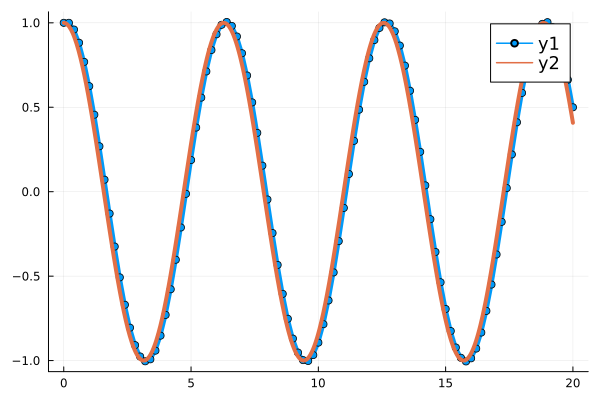

In [117]:
f1(t, y; k=10) = -k * (y .- cos(t))

thist, yhist = ode_euler(f1, [1.], tfinal=20, h=.2)
plot(thist, yhist[1,:], marker=:circle)
plot!(cos)

# Forward Euler on a linear system

$$ \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}' = \begin{bmatrix} 0 & 1 \\ -1 & 0 \end{bmatrix} \begin{bmatrix} y_1 \\ y_2 \end{bmatrix}$$

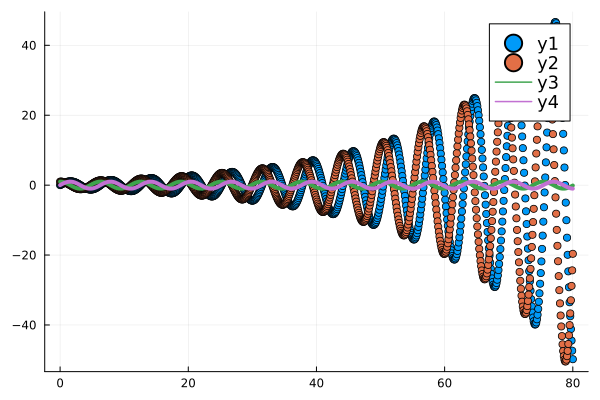

In [118]:
f2(t, y) = [0 1; -1 0] * y

thist, yhist = ode_euler(f2, [0., 1], h=.1, tfinal=80)
scatter(thist, yhist')
plot!([cos, sin])

In [5]:
eigvals([0 1; -1 0])

2-element Vector{ComplexF64}:
 0.0 - 1.0im
 0.0 + 1.0im

# Runge-Kutta 4

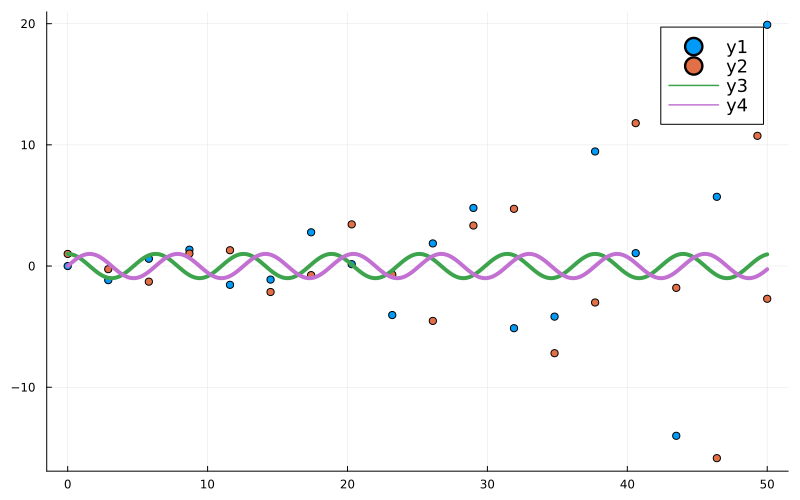

In [127]:
thist, yhist = ode_rk_explicit(f2, [0., 1], h=2.9, tfinal=50)
scatter(thist, yhist')
plot!([cos, sin], size=(800, 500))

* Apparently it is possible to integrate this system using large time steps.
* This method evaluates $f(y)$ four times per stepso the cost is about equal when the step size $h$ is 4x larger than forward Euler.

# Linear Stability Analysis

Why did Euler diverge (even if slowly) while RK4 solved this problem accurately?
And why do both methods diverge if the step size is too large?
We can understand the convergence of methods by analyzing the test problem
$$ y' = \lambda y $$
for different values of $\lambda$ in the complex plane.
One step of the Euler method with step size $h$ maps
$$ y \mapsto y + h \lambda y = \underbrace{(1 + h \lambda)}_{R(h \lambda)} y .$$
When does this map cause solutions to "blow up" and when is it stable?

In [7]:
function plot_stability(Rz, method; xlim=(-3, 2), ylim=(-1.5, 1.5))
    x = xlim[1]:.02:xlim[2]
    y = ylim[1]:.02:ylim[2]
    plot(title="Stability: $method", aspect_ratio=:equal, xlim=xlim, ylim=ylim)
    heatmap!(x, y, (x, y) -> abs(Rz(x + 1im*y)), c=:bwr, clims=(0, 2))
    contour!(x, y, (x, y) -> abs(Rz(x + 1im*y)), color=:black, linewidth=2, levels=[1.])
    plot!(x->0, color=:black, linewidth=1, label=:none)
    plot!([0, 0], [ylim...], color=:black, linewidth=1, label=:none)
end

plot_stability (generic function with 1 method)

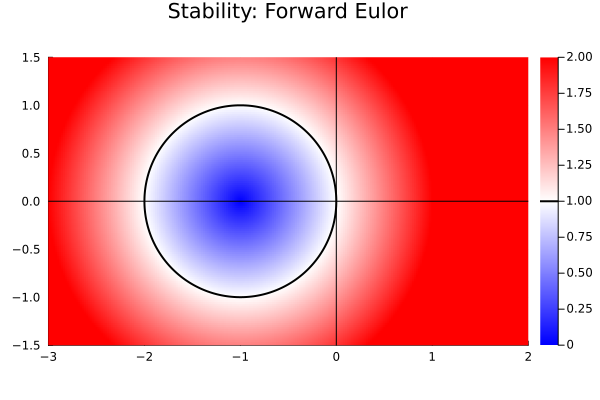

In [8]:
plot_stability(z -> 1 + z, "Forward Eulor")

# Stability for RK4

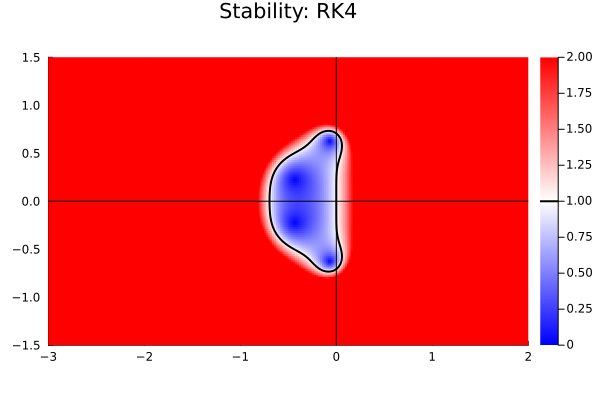

In [9]:
plot_stability(z -> rk_stability(4z, rk4), "RK4")


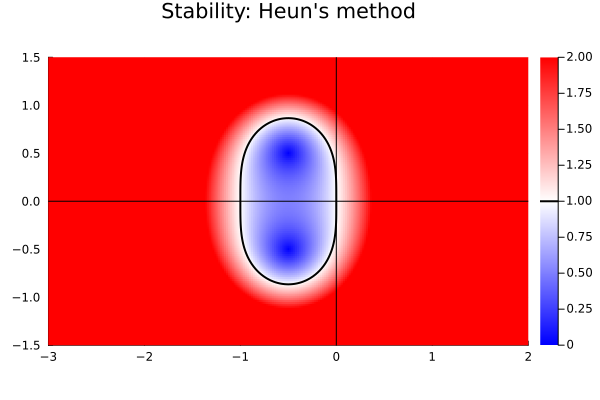

In [10]:
plot_stability(z -> rk_stability(2z, heun), "Heun's method")

# Implicit methods

Recall that forward Euler is the step
$$ \tilde y(h) = y(0) + h f(0, y(0)) . $$
This can be evaluated **explicitly**; all the terms on the right hand side are known so the approximation $\tilde y(h)$ is computed merely by evaluating the right hand side.
Let's consider an alternative, **backward Euler** (or "implicit Euler"),
$$ \tilde y(h) = y(0) + h f(h, \tilde y(h)) . $$
This is a (generally) nonlinear equation for $\tilde y(h)$.
For the test equation $y' = \lambda y$, the backward Euler method is
$$ \tilde y(h) = y(0) + h \lambda \tilde y(h) $$
or
$$ \tilde y(h) = \underbrace{\frac{1}{1 - h \lambda}}_{R(h\lambda)} y(0) . $$

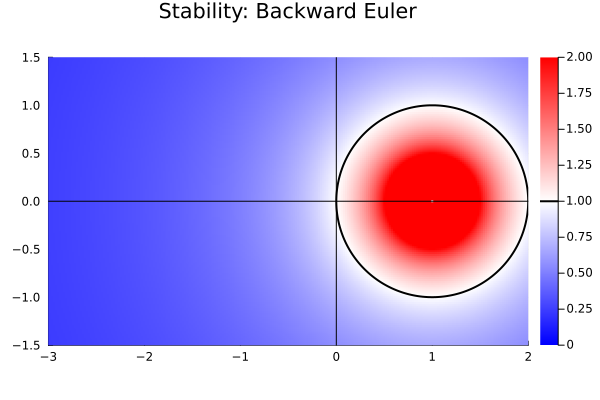

In [11]:
plot_stability(z -> 1/(1-z), "Backward Euler")

# Computing with implicit methods

$$ \tilde y(h) = y(0) + h f\big(\tilde y(h) \big) $$

* Linear solve for linear problem
* Nonlinear (often Newton) solve for nonlinear problem
* Need Jacobian or finite differencing

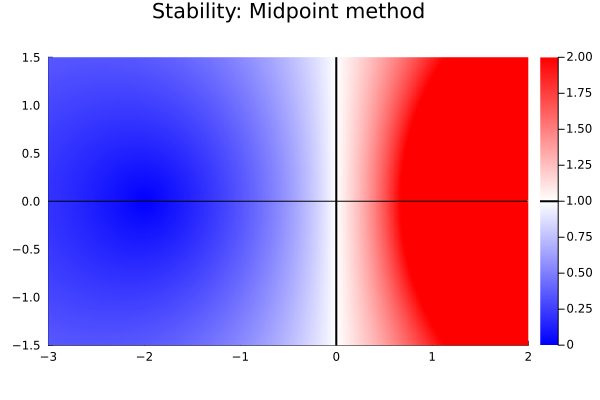

In [12]:
plot_stability(z -> Rz_theta(z, .5), "Midpoint method")

# The $\theta$ method


Forward and backward Euler are bookends of the family known as $\theta$ methods.

$$ \tilde u(h) = u(0) + h f\Big(\theta h, \theta\tilde u(h) + (1-\theta)u(0) \Big) $$

which, for linear problems, is solved as

$$ (I - h \theta A) u(h) = \Big(I + h (1-\theta) A \Big) u(0) . $$

$\theta=0$ is explicit Euler, $\theta=1$ is implicit Euler, and $\theta=1/2$ are the midpoint or trapezoid rules (equivalent for linear problems).
The stability function is
$$ R(z) = \frac{1 + (1-\theta)z}{1 - \theta z}. $$

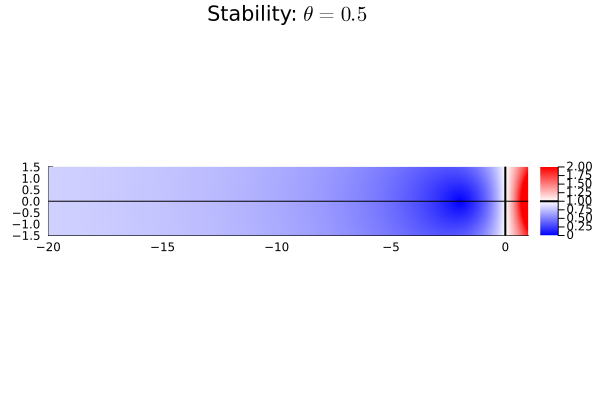

In [132]:
Rz_theta(z, theta) = (1 + (1-theta)*z) / (1 - theta*z)
theta = .5
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta\$", 
    xlim=(-20, 1))

# $\theta$ method for the oscillator

In [14]:
function ode_theta_linear(A, u0; forcing=zero, tfinal=1, h=0.1, theta=.5)
    u = copy(u0)
    t = 0.
    thist = [t]
    uhist = [u0]
    while t < tfinal
        tnext = min(t+h, tfinal)
        h = tnext - t
        rhs = (I + h*(1-theta)*A) * u .+ h*forcing(t+h*theta)
        u = (I - h*theta*A) \ rhs
        t = tnext
        push!(thist, t)
        push!(uhist, u)
    end
    thist, hcat(uhist...)
end

ode_theta_linear (generic function with 1 method)

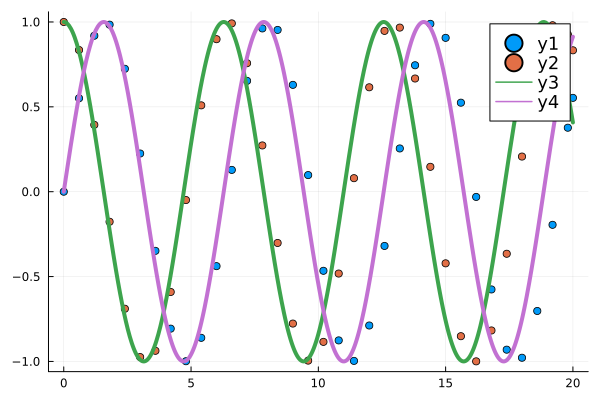

In [140]:
# Test on oscillator
A = [0 1; -1 0]
theta = .5
thist, uhist = ode_theta_linear(A, [0., 1], h=.6, theta=theta, tfinal=20)
scatter(thist, uhist')
plot!([cos, sin])

# $\theta$ method for the cosine decay

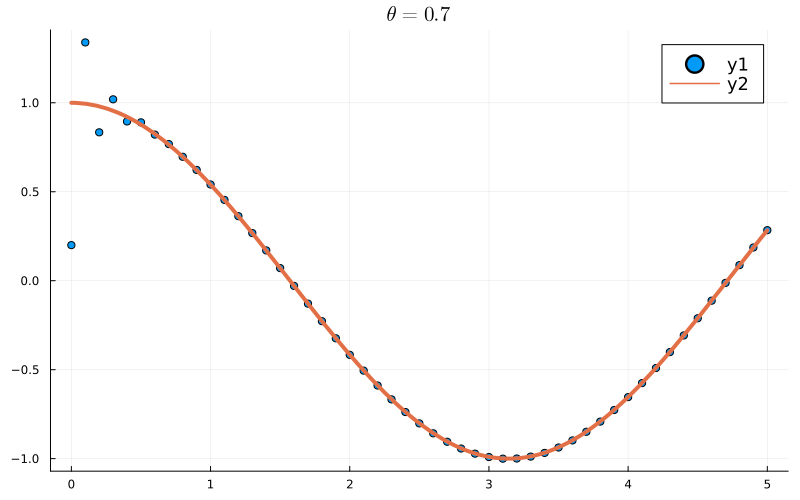

In [169]:
k = 500000
theta = .7
thist, uhist = ode_theta_linear(-k, [.2], forcing=t -> k*cos(t), tfinal=5, h=.1, theta=theta)
scatter(thist, uhist[1,:], title="\$\\theta = $theta\$")
plot!(cos, size=(800, 500))

# Stability classes and the $\theta$ method


## Definition: $A$-stability
A method is $A$-stable if the stability region
$$ \{ z : |R(z)| \le 1 \} $$
contains the entire left half plane $$ \Re[z] \le 0 .$$
This means that the method can take arbitrarily large time steps without becoming unstable (diverging) for any problem that is indeed physically stable.

## Definition: $L$-stability
A time integrator with stability function $R(z)$ is $L$-stable if
$$ \lim_{z\to\infty} R(z) = 0 .$$
For the $\theta$ method, we have
$$ \lim_{z\to \infty} \frac{1 + (1-\theta)z}{1 - \theta z} = \frac{1-\theta}{\theta} . $$
Evidently only $\theta=1$ is $L$-stable.

# Heat equation as linear ODE

* How do different $\theta \in [0, 1]$ compare in terms of stability?
* Are there artifacts even when the solution is stable?

In [107]:
using SparseArrays

function heat_matrix(n)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i, i])
        append!(cols, wrap.([i-1, i, i+1]))
        append!(vals, [1, -2, 1] ./ dx^2)
    end
    sparse(rows, cols, vals)
end
heat_matrix(5)

5×5 SparseMatrixCSC{Float64, Int64} with 15 stored entries:
 -12.5     6.25     ⋅       ⋅      6.25
   6.25  -12.5     6.25     ⋅       ⋅ 
    ⋅      6.25  -12.5     6.25     ⋅ 
    ⋅       ⋅      6.25  -12.5     6.25
   6.25     ⋅       ⋅      6.25  -12.5

  0.001373 seconds (846 allocations: 1.483 MiB)


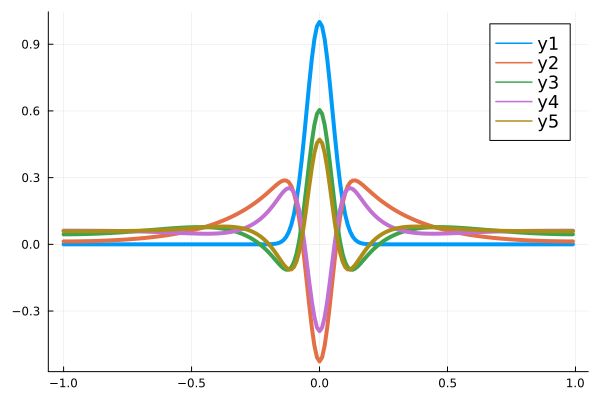

In [111]:
n = 200
A = heat_matrix(n)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-200 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.1, theta=.5, tfinal=1);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:5])

# Advection as a linear ODE

In [19]:
function advect_matrix(n; upwind=false)
    dx = 2 / n
    rows = [1]
    cols = [1]
    vals = [0.]
    wrap(j) = (j + n - 1) % n + 1
    for i in 1:n
        append!(rows, [i, i])
        if upwind
            append!(cols, wrap.([i-1, i]))
            append!(vals, [1., -1] ./ dx)
        else
            append!(cols, wrap.([i-1, i+1]))
            append!(vals, [1., -1] ./ 2dx)
        end
    end
    sparse(rows, cols, vals)
end
advect_matrix(5)

5×5 SparseMatrixCSC{Float64, Int64} with 11 stored entries:
  0.0   -1.25    ⋅      ⋅     1.25
  1.25    ⋅    -1.25    ⋅      ⋅ 
   ⋅     1.25    ⋅    -1.25    ⋅ 
   ⋅      ⋅     1.25    ⋅    -1.25
 -1.25    ⋅      ⋅     1.25    ⋅ 

  0.075686 seconds (154.41 k allocations: 9.739 MiB, 97.59% compilation time)


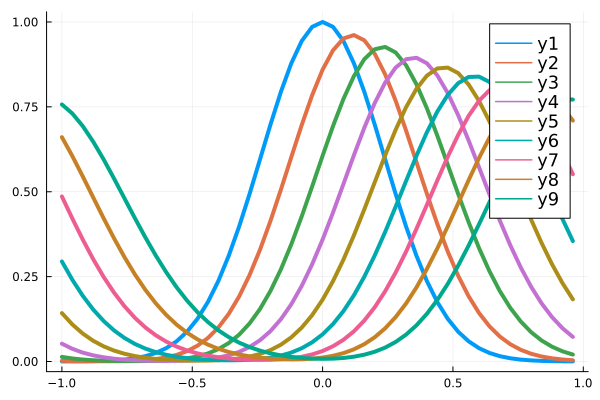

In [20]:
n = 50
A = advect_matrix(n, upwind=false)
x = LinRange(-1, 1, n+1)[1:end-1]
u0 = exp.(-9 * x .^ 2)
@time thist, uhist = ode_theta_linear(A, u0, h=.04, theta=1, tfinal=1.);
nsteps = size(uhist, 2)
plot(x, uhist[:, 1:(nsteps÷8):end])

# Spectrum of operators

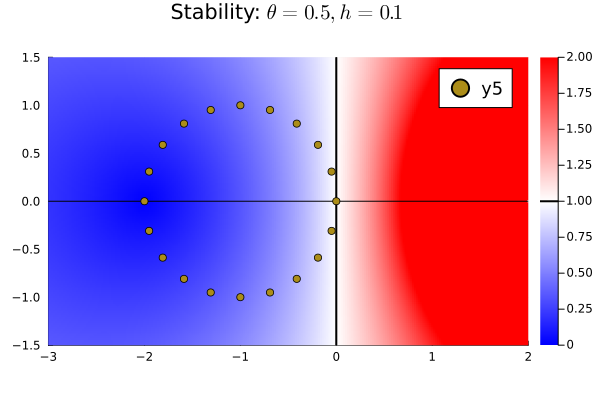

In [21]:
theta=.5
h = .1
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*advect_matrix(20, upwind=true)))
scatter!(real(ev), imag(ev))

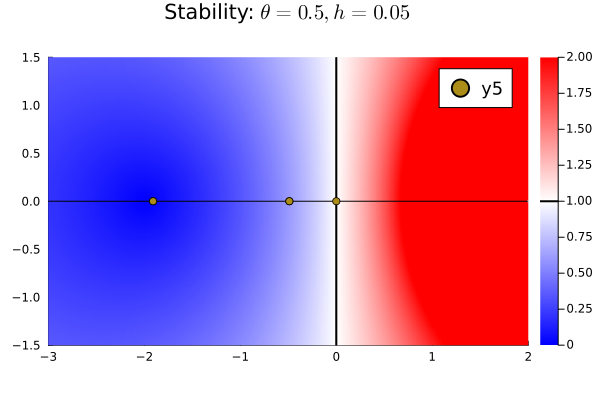

In [22]:
theta=.5
h = .2 / 4
plot_stability(z -> Rz_theta(z, theta), "\$\\theta=$theta, h=$h\$")
ev = eigvals(Matrix(h*heat_matrix(20)))
scatter!(real(ev), imag(ev))